In [32]:
from tensorflow.keras import datasets

In [33]:
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [34]:
import numpy as np
def reprocess(imgs):
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs , ((0,0), (2,2), (2,2)), constant_values= -1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [35]:
x_train.shape

(60000, 28, 28)

In [36]:
x_train = reprocess(x_train)
x_test = reprocess(x_test)

In [37]:
import tensorflow as tf

x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

The Energy function uses activation function called `swish`

$$
\text{swish}(x) = x . \text{sigmoid} (x) = x\frac{1} {1 + \epsilon^{-x}}
$$

Plot of swish function:

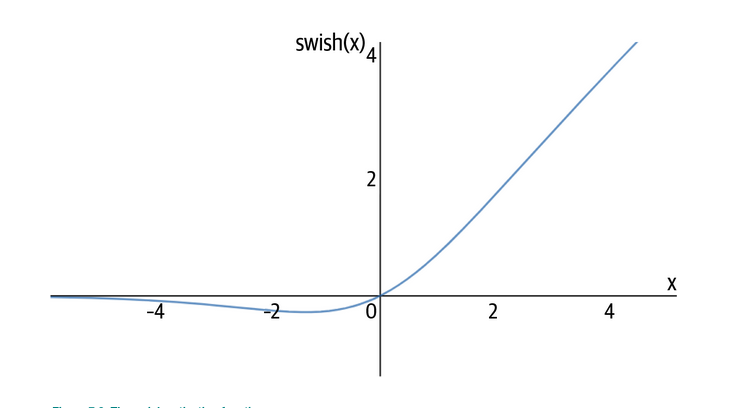

In [49]:
from tensorflow.keras import activations, layers, models

def energy_model():
    ebm_input = layers.Input(shape=(32, 32, 1))
    x = layers.Conv2D(
        16, kernel_size=5, strides=2, padding="same", activation = activations.swish
    )(ebm_input)
    x = layers.Conv2D(
        32, kernel_size=3, strides=2, padding="same", activation = activations.swish
    )(x)
    x = layers.Conv2D(
        64, kernel_size=3, strides=2, padding="same", activation = activations.swish
    )(x)
    x = layers.Conv2D(
        64, kernel_size=3, strides=2, padding="same", activation = activations.swish
    )(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation = activations.swish)(x)
    ebm_output = layers.Dense(1)(x)
    model = models.Model(ebm_input, ebm_output)
    return model

In [50]:
energy_model = energy_model()

In [55]:
def generate_samples(model, inp_imgs, steps, step_size, noise):
    """Langevin dynamic resample"""
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean = 0, stddev = noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = -model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -0.03, 0.03)
        inp_imgs += -step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
    return inp_imgs